# Importing Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import math
import cv2

pd.set_option('display.max_columns', 500)

In [2]:
town_path = "C:/Users/HP/Desktop/district_census/data/town.csv"
village_path = "C:/Users/HP/Desktop/district_census/data/village.csv"
location_path = "C:/Users/HP/Desktop/district_census/data/location.csv"

town_raw = pd.read_csv(town_path, encoding = 'ISO-8859-1')
village_raw = pd.read_csv(village_path, encoding = 'ISO-8859-1')
location_raw = pd.read_csv(location_path, encoding = 'ISO-8859-1')

C:\Users\HP\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (0,2,4,6,377) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Defining Functions

## Work of all defined functions:

### 1. extract_columns : Extract selected columns from Dataset, give list of required columns and/or start and end index of column range
### 2. pop_density : Adds a population density column to a given dataframe, given indices of population and area columns
### 3. distance_from_coordinates : Using Haversine algorithm to calculate distance between two given coordinates in kilometers
### 4. add_coordinates : Adds Latitude, Longitude columns to original town and village datasets given location dataset, town/village dataset, and respective column name
### 5. edit_names : Edits names of towns and villages to match as given in the Dataset containing their coordinates given town/village dataset and column name containing names
### 6. tidier : The function edit_names fails to add coordinates of all towns and villages as given in location dataset. So the function tidier adds those which are left given location dataset and town/village dataset
### 7. add_nodes : This function adds all the nodes (towns and villages) to the Graph created using nested lists.
### 8. medical_score : This function attributes a medical score to each town/village 
### 9. normalize_medical_score : This function normalizes the medical score values between 0 and 1
### 10. add_edges : This function adds edges to the Graph created
### 11. closest_medical_facilities : This function returns closest medical facilities of a given town/village

In [3]:
def extract_columns(df, selected_columns, a, b):
    
    return pd.concat([df.loc[:,selected_columns], df.iloc[:,a:b]], axis = 1)
# Merging two dataframes to get village DataFrame concerning medical columns


In [4]:
def pop_density(df, idx_pop, idx_area):
   
    density = []
    for i in range(0, df.shape[0]):
        density.append(df.iloc[i,idx_pop]/df.iloc[i,idx_area])
        
    df['Population Density'] = density
    return df

In [5]:
def distance_from_coordinates(coord1, coord2):
    
    lat1 = coord1[0]
    lat2 = coord2[0]
    long1 = coord1[1]
    long2 = coord2[1]
    
    dLat = (lat2 - lat1) * math.pi / 180.0
    dLon = (long2 - long1) * math.pi / 180.0
    
    lat1 = (lat1) * math.pi / 180.0
    lat2 = (lat2) * math.pi / 180.0
  
    a = (pow(math.sin(dLat / 2), 2) + 
         pow(math.sin(dLon / 2), 2) * 
             math.cos(lat1) * math.cos(lat2)); 
    radius = 6371
    c = 2 * math.asin(math.sqrt(a)) 
    return radius * c 

In [6]:
def add_coordinates(df, df_loc, df_name, df_loc_name):
    latitudes = []
    longitudes = []
    for i in range(0, df.shape[0]):
        name = df.iloc[i,df.columns.get_loc(df_name)]
        
        lats = np.array(df_loc[df_loc[df_loc_name] == name]["Latitude"])
        longs = np.array(df_loc[df_loc[df_loc_name] == name]["Longitude"])
        
        try:
            latitudes.append(lats[0])
            longitudes.append(longs[0])
            
        except IndexError:
            latitudes.append(None)
            longitudes.append(None)
         
    #print(len(latitudes), len(longitudes))
    #print(df.shape)
    df["Latitude"] = latitudes
    df["Longitude"] = longitudes
    return df

In [7]:
def edit_names(df, column):
    names_ = list(df[column])
    idx_ = df.columns.get_loc(column)
    names = []
    for name in names_:
        idx = 0
        for i in name:
            if i != '(':
                idx = idx+1
            else:
                break
        names.append(name[:idx])
        
    #df.drop(column, axis=1)
    df.insert(loc=idx_, column="_Name_", value=names)
                
    return df

In [8]:
def tidier(df, df_loc):

    nans = town_medical[town_medical["Latitude"].isna()]

    names = nans["_Name_"]
    names = np.array(names)
    lats = []
    longs = []
    for name in names:
        name_ = name[:-1]
        lat = np.array(df_loc[df_loc["_Name_"] == name_]["Latitude"])
        long = np.array(df_loc[df_loc["_Name_"] == name_]["Longitude"])
        if lat.shape[0] > 0:
            lat = lat[0]
            long = long[0]
        else:
            lat = None
            long = None
        
        lats.append(lat)
        longs.append(long)
    
    idcs = df.index[df['Latitude'].isna()].tolist()

    i = 0
    for idx in idcs:
        df.iloc[idx, df.columns.get_loc("Latitude")] = lats[i]
        df.iloc[idx, df.columns.get_loc("Longitude")] = longs[i]
        i = i+1
        
    return df

In [9]:
def add_nodes(G, df, places_to_num, type_, column = "_Name_"):
    coordinates = []
    names = []
    scores = []
    scaled = []
    for i in range(0, df.shape[0]):
        name = df.iloc[i, df.columns.get_loc(column)]
        if name[-1] == " ":
            names.append(name[:-1])
        else:
            names.append(name)
            
        lat = df.iloc[i, df.columns.get_loc("Latitude")]
        long = df.iloc[i, df.columns.get_loc("Longitude")]
        score = df.iloc[i, df.columns.get_loc("Medical_Score")]
        sc = df.iloc[i, df.columns.get_loc("Normalized_Medical_Score")]
        
        if math.isnan(score):
            score = 0
            
        scores.append(score)
        scaled.append(sc)
        coordinates.append((lat, long))
        
    for i in range(0, len(names)):
        if math.isnan(coordinates[i][0]) == False:
            #G.add_node(names[i], pos = coordinates[i], alias = type_, medical_score = scores[i], normalized_score = scaled[i])
            properties = []
            properties.append(names[i])
            properties.append(coordinates[i])
            properties.append(type_)
            properties.append(scores[i])
            properties.append(scaled[i])
            properties.append([])
            
            val = places_to_num[names[i]]
            G[val] = properties
            
    return G

In [10]:
def medical_score(p1, p2, p3, p4, p5, df, wp1 = 100.0, wp2 = 40.0, wp3 = 15.0, wp4 = 5.0, wp5 = 2.0):
    scores = []
    error = 0
    for i in range(0, df.shape[0]):
        score = 0
        for param in p1:
            
            try:
                val_ = np.array(df.iloc[i, param])
                score += float(val_)*wp1
            except ValueError:
                error += 1
        for param in p2:
            try:
                val_ = np.array(df.iloc[i, param])
                score += float(val_)*wp2
            except ValueError:
                error += 1
        for param in p3:
            try:
                val_ = np.array(df.iloc[i, param])
                score += float(val_)*wp3
            except ValueError:
                error += 1
                
        for param in p4:
            try:
                val_ = np.array(df.iloc[i, param])
                score += float(val_)*wp4
            except ValueError:
                error += 1
                
        for param in p5:
            try:
                val_ = np.array(df.iloc[i, param])
                score += float(val_)*wp5
            except ValueError:
                error += 1
                
        scores.append(score)
        
    df["Medical_Score"] = scores
    print(error)
    return df

In [11]:
def normalize_medical_score(df):
    max_ = df["Medical_Score"].max()
    scaled = []
    for i in range(0, df.shape[0]):
        val = df.iloc[i, -1]
        scaled.append(val/max_)
        
    df["Normalized_Medical_Score"] = scaled
    return df

In [12]:
def add_edges(G, places_to_num, distance_threshold):
    #nodes = list(G.keys())
    nodes = []
    error=0
    try:
        for i in range(0, len(G)):
            nodes.append(G[i][0])
            
    except IndexError:
        error += 1
    for node in nodes:
        val = places_to_num[node]
        alias = G[val][2]
        coord1 = G[val][1]
        medical_score = G[val][3]
        for node_ in nodes:
            val_ = places_to_num[node_]
            coord2 = G[val_][1]
            distance = distance_from_coordinates(coord1, coord2)
            alias_ = G[val_][2]
            score = G[val_][3]
            
            if alias == 'town' and alias_ == 'village':
                pass
            else:
                if distance <= distance_threshold and score > medical_score and distance > 0:
                    #G.add_edge(node, node_, distance = distance, relative_affinity = ((score-medical_score)/distance))
                    G[val][5].append((node_, distance, ((score-medical_score)/distance)))
                    
    
    print(error)                
    return G

In [13]:
def closest_medical_facilities(G, name, places_to_num):
    val = places_to_num[name]
    neighbours = G[val][5]
    for neighbour in neighbours:
        name_ = neighbour[0]
        dist = neighbour[1]
        affinity = neighbour[2]
        
        print("Name: ", name_, " Distance: ", dist, " Affinity: ", affinity)

In [14]:
village_columns_filter = ['District Code', 
                          'District Name', 
                          'Village Code', 
                          'Village Name', 
                          'Reference Year', 
                          'Total Geographical Area (in Hectares)', 
                          'Total   Households ', 
                          'Total Population of Village',
                          'Total Male Population of Village',
                          'Total Female Population of Village', 
                          'Nearest Town Name',
                          'Nearest Town Distance from Village (in Km.)', 
                          'Govt Medicine College (Status A(1)/NA(2))',
                          'Govt Medicine  College (Numbers)',
                          'Private Medicine  College (Status A(1)/NA(2))',
                          'Private Medicine College (Numbers)'
                         ]

town_columns_filter = ['District Code',
                     'District Name',
                     'Town Code',
                     'Town Name',
                     'Total   Households ',
                     'Total Population of Town',
                     'Total Male Population of Town',
                     'Total Female Population of Town',      
                     'Reference Year',
                     'Class',
                     'Civic Status of Town',
                     'Area (sq. km.)',
                     'Nearest Ciity Name with Population of 1 Lakh and more',
                     'Nearest Ciity with Population of 1 Lakh and more Road Distance (in kms.) ',
                     'Nearest Ciity Name with Population of 5 Lakh and more',
                     'Nearest Ciity with Population of 5 Lakh and more Road Distance (in kms.) ',
                        ]

These are all the column headers for towns and villages that we need. Besides these for towns we need columns indexed between 102 and 183 and for villages those between 132 and 207. Using defined function 'extract_column', we create 2 new Datasets : 
1. village_medical : Deals with medical data pertaining all villages
2. town_medical : Deals with medical data pertaining all towns

In [15]:
village_medical = extract_columns(village_raw, village_columns_filter, 132, 207)
town_medical = extract_columns(town_raw, town_columns_filter, 102, 183)

The area in Village dataset is given in hectares. We need to convert to square kilometers.

In [16]:
# Changing area of villages to square kilometer and renaming the same column

for i in range(0, village_medical.shape[0]):
    village_medical.iloc[i,5] = village_raw.iloc[i,23]/100
   


Using user_defined function 'pop_density' we add a Population Density column to both town_medical and village_medical Datasets.

In [17]:
village_medical = pop_density(village_medical, 7, 5) # pop_density(dataset, column index of population, column index of area) 
town_medical = pop_density(town_medical, 5, 11)

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


Using user-defined function 'edit_names', we edit names of towns in town_medical and location datasets and add an extra column headed '_Name_' in both which stores just the name of the towns removing all parentheses.

Then, 'add_coordinates' is used to add Latitude and Longitude columns to both town_medical and village_medical datasets, the values of which are given in location dataset.

But certain towns don't have their coordinates added in town_medical dataset because of slight differences in names in town_medical and location datasets (chiefly arising due to presence of unwanted spaces). The user-defined 'tidier' function mends this problem

In [18]:
location_raw = edit_names(location_raw, "Town/Village Name") #edit_names(dataframe, column name containing names)

town_medical = edit_names(town_medical, "Town Name")

In [19]:
town_medical = add_coordinates(town_medical, location_raw, "_Name_", "_Name_")
# add_coordinates(town/village dataframe, location dataframe, column name containing names in town/village, column name containing names in location)
village_medical = add_coordinates(village_medical, location_raw, "Village Name","_Name_")

In [20]:
town_medical = tidier(town_medical, location_raw)

In [21]:
names = []
for i in range(0, village_medical.shape[0]):
    name = village_medical.iloc[i, village_medical.columns.get_loc("Village Name")]
    names.append(str(name))
    
village_medical["_Name_"] = names

# This is to add a column in village_medical Dataset called '_Name_' containing names of all villages

#### We give attributes to each node like its position(latitude, longitude), type(town/village), medical score.
#### All the edges are directed. They have 2 attributes: distance and proability of the source to go to destination for
#### medical purposes, which is calculated by given threshold values of inclination to travel

In [22]:
tp1 = [17, 24, 66]
tp2 = [18, 19, 25, 26, 67, 68, 45, 52, 31, 38]
tp3 = [46, 47, 53, 54, 39, 40, 32, 33, 59, 80]
tp4 = [60, 61, 81, 82, 94, 95, 96, 20, 27, 34, 69, 48, 55]
tp5 = [41, 62, 83, 87, 88, 89, 90, 97, 21, 22, 28, 29, 35, 36, 41, 42, 43, 49, 50, 56, 57, 63, 64, 70, 71, 84, 85, 91, 92]

vp1 = [46, 52]
vp2 = [47, 48, 53, 54, 16, 22, 34, 76, 58]
vp3 = [17, 18, 23, 24, 35, 36, 59, 60, 77, 38, 28, 70, 40]
vp4 = [29, 30, 41, 42, 71, 72]
vp5 = [82, 83, 84, 85, 86, 87, 88, 89, 90, 19, 20, 25, 26, 31, 32, 33, 37, 38, 43, 44, 49, 50, 55, 56, 61, 62, 73, 74, 79, 80]

# these lists contain the indices of columns in town_medical and village_medical datasets, based on which medical_score is to
# be calculated. tp1 contains list of factors which has maximum impact on medical score of a town, for example Number of 
# Allopathic hospitals, Nursing Homes etc. Similarly the rest follows

In [23]:
town_medical = medical_score(tp1, tp2, tp3, tp4, tp5, town_medical.fillna(0))
# the respective weights assigned to properties of different priorities are given as default parameters
village_medical = medical_score(vp1, vp2, vp3, vp4, vp5, village_medical.fillna(0))


1
25000


In [24]:
town_medical = normalize_medical_score(town_medical)
village_medical = normalize_medical_score(village_medical)

In [25]:
places_to_num = {}

idx = 0
for i in range(0, town_medical.shape[0]):
    name = town_medical.iloc[i, town_medical.columns.get_loc("_Name_")]
    if name[-1] == " ":
        name = name[:-1]
    places_to_num[name] = idx
    idx += 1
    
for i in range(0, village_medical.shape[0]):
    name = village_medical.iloc[i, village_medical.columns.get_loc("_Name_")]
    
    if name[-1] == " ":
        name = name[:-1]
    places_to_num[name] = idx
    idx += 1
    


A number is assigned to each town and village so that listwise Graph creation becomes possible. This is made in form of a dictionary, 'places_to_num' indexing place names to numbers

In [26]:
Map = []
for i in range(0, town_medical.shape[0]+village_medical.shape[0]):
    Map.append([])

Map = add_nodes(Map, town_medical, places_to_num, type_ = "town")
Map = add_nodes(Map, village_medical, places_to_num, type_ = "village")

In [27]:
Map = add_edges(Map, places_to_num, distance_threshold = 500)
# distance_threshold is the maximum distance one is willing to travel

1


Map is the Graph created. Map is essentially a list. 
Given a certain town/village name, we get the unique number assigned to it from the previously created dictionary 'places_to_num'. Suppose this number is j.
The jth index of Map is again a list containing 6 elements:
1. Name of town/village
2. Coordinates of town/village
3. type (whether town or village)
4. Medical Score
5. Normalized Medical Score

----------These 5 are essentially node attributes---------
6. This is again a list which contains 3 elements:
    a. Name of town/village it is connected to
    b. Distance between these two
    c. Relative Affinity of a person in the first place to visit the second for medical treatment.
    
-------------These 3 are essentially edge attributes----------------

In [28]:
name = 'Kurseong'
closest_medical_facilities(Map, name, places_to_num)

Name:  Darjiling  Distance:  19.459905852613627  Affinity:  640.1367043780904
Name:  Kalimpong  Distance:  27.29664843349874  Affinity:  344.58442848451887


Given the name of a town/village, user-defined function 'closest_medical_facilities' returns nearest towns (for a given town) or nearest towns and villages (for a given village) where one from given town/village may go for medical treatment. Also distance and relative affinitty to go are also given

## For district-wise medical Distribution following steps:

In [54]:
district = 'SOUTH  TWENTY FOUR PARGANAS'
district_ = 'South Twenty Four Parganas'

bdm_towns = town_medical[town_medical["District Name"] == district]
bdm_villages = village_medical[village_medical["District Name"] == district_]

bdm_towns = bdm_towns.drop('Normalized_Medical_Score', axis=1)
bdm_villages = bdm_villages.drop('Normalized_Medical_Score', axis=1)

bdm_towns = normalize_medical_score(bdm_towns)
bdm_villages = normalize_medical_score(bdm_villages)


Town and Village medical data for Bardhaman are extracted and stored in bdm_towns and bdm_villages respectively.
The medical scores are again normalized thereby

# Defining Functions for Districtwise Data

## Use of Defined Functions:
### 1. bounding_box_coordinates : Given datasets of towns and villages returns the top-left and bottom-right coordinates of the bounding box of the region alongwith the length and width of the region.
### 2. plot_image : Plots a given image clearly
### 3. ret_bound : Given a coordinate and a distance d, returns top-left and bottom-right coordinates of bounding box with width d
### 4. sub_part : Given top-left and bottom-right coordinates of a bounding box and dimensions of original image, returns index where the bounding box lies within given image
### 5. return_coords : Given town and village datasets, returns list called coordinates, each element of which consists of coordinates, name, score and type (town or village)
### 6. insert_boxes : Plots all the towns and villages according to position in the given image
### 7. make_dict : Given score-coefficient (weightage given to score) and distance-coefficient(willingness to travel), returns dictionary of all villages pointing to corresponding towns on which it is medically dependant
### 8. final_image : Given name of a certain town, returns an image marking the town and all villages medically dependant on town

In [69]:
def bounding_box_coordinates(df1, df2):
    coordinates = []
    for i in range(0, df1.shape[0]):
        lat = df1.iloc[i, df1.columns.get_loc("Latitude")]
        long = df1.iloc[i, df1.columns.get_loc("Longitude")]
        
        if math.isnan(lat) or int(lat) < 21 or int(lat) > 22:
            pass
        else:
            coordinates.append((lat, long))
            
    for i in range(0, df2.shape[0]):
        lat = df2.iloc[i, df2.columns.get_loc("Latitude")]
        long = df2.iloc[i, df2.columns.get_loc("Longitude")]
        
        if math.isnan(lat) or int(lat) < 21 or int(lat) > 22:
            pass
        else:
            coordinates.append((lat, long))
            
    maxlat = -999999
    minlat = 999999
    maxlong = -999999
    minlong = 999999
    left = (0,0)
    right = (0,0)
    top = (0,0)
    bottom = (0,0)
    for coord in coordinates:
        if math.isnan(coord[0]):
            pass
        else:
            
            if coord[0] > maxlat:
                top = (coord[0], coord[1])
                maxlat = coord[0]
           
            if coord[0] < minlat:
                bottom = (coord[0], coord[1])
                minlat = coord[0]
        
            if coord[1] > maxlong:
                right = (coord[0], coord[1])
                maxlong = coord[1]
            
            if coord[1] < minlong:
                left = (coord[0], coord[1])
                minlong = coord[1]
                
    length = distance_from_coordinates(left, right)
    width = distance_from_coordinates(top, bottom)
    
    bbox = [(top[0], left[1]), (bottom[0], right[1])]
    print(left, right, top, bottom)
    
    return length,width,bbox

In [56]:
def plot_image(arr):
    plt.figure(figsize=(20, 20))
    
    plt.imshow(arr)

In [57]:
def ret_bound(coord,d):
    lat1 = coord[0]
    long1 = coord[1]
    top = d/111111
    left = top/math.cos(lat1/180*math.pi)
    coords = [(lat1+top, long1-left),(lat1-top, long1+left)]
    return coords

In [58]:
def sub_part(a,b,coord2,bbox):

    lat11,long11 = bbox[0]
    lat12,long12 = bbox[1]
    lat21,long21 = coord2[0]
    lat22,long22 = coord2[1]
    x1 = int(b*(lat21-lat11)/(lat12-lat11))
    x2 = int(a*(long21-long11)/(long12-long11))
    y1 = int(b*(lat22-lat11)/(lat12-lat11))
    y2 = int(a*(long22-long11)/(long12-long11))

    return x1,x2,y1,y2

In [59]:
def return_coords(bdm_towns, bdm_villages):
    
    coords = []
    if bdm_towns is not None:
        for i in range(0, bdm_towns.shape[0]):
            lat = bdm_towns.iloc[i, bdm_towns.columns.get_loc("Latitude")]
            long = bdm_towns.iloc[i, bdm_towns.columns.get_loc("Longitude")]
            name = bdm_towns.iloc[i, bdm_towns.columns.get_loc("_Name_")]
            score = bdm_towns.iloc[i, bdm_towns.columns.get_loc("Medical_Score")]
    
            if math.isnan(lat):
                pass
            else:
                coords.append((lat, long, name, score, "town"))
        

    if bdm_villages is not None:
        for i in range(0, bdm_villages.shape[0]):
            lat = bdm_villages.iloc[i, bdm_villages.columns.get_loc("Latitude")]
            long = bdm_villages.iloc[i, bdm_villages.columns.get_loc("Longitude")]
            name = bdm_villages.iloc[i, bdm_villages.columns.get_loc("_Name_")]
            score = bdm_villages.iloc[i, bdm_villages.columns.get_loc("Medical_Score")]
    
            if math.isnan(lat):
                pass
            else:
                coords.append((lat, long, name, score, "village"))
        
    return coords

In [60]:
def insert_boxes(parts, blank):
    towns = 0
    villages = 0
    for i in range(0, len(parts)):
        alias = parts[i][1]
        if alias == "town":
            towns += 1
            color = (255, 255, 255)
            #norm_score = np.array(bdm_towns[bdm_towns['Latitude'] == coords[i][0]]['Normalized_Medical_Score'])[0]
        else:
            villages += 1
            color = (255, 0, 0)
            #norm_score = np.array(bdm_villages[bdm_villages['Latitude'] == coords[i][0]]['Normalized_Medical_Score'])[0]

        topleft = (parts[i][0][0], parts[i][0][1])
        bottomright = (parts[i][0][2], parts[i][0][3])

        cv2.rectangle(blank, topleft, bottomright, color, thickness=-1) 

    # Towns are White, Villages are Red
    print(towns, villages)
    
    return blank

In [61]:
def make_dict(coords, score_coefficient, distance_coefficient):
    vill_town = {}

    coords_town = []
    coords_village = []
    for coord in coords:
        if coord[4] == 'town':
            coords_town.append(coord)
        
        else:
            coords_village.append(coord)
    

    for cv in coords_village:
        max_ = -99999999
        coord1 = (cv[0], cv[1])
        for ct in coords_town:
            coord2 = (ct[0], ct[1])
            dist = distance_from_coordinates(coord1, coord2)
            score_ = ct[3]
            
            affinity = (score_*score_coefficient) - (dist*distance_coefficient)
            max_ = max(max_, affinity)
            if max_ == affinity:
                name_t = ct[2]
            
        name_v = cv[2]
        if name_v[-1] == " ":
            name_v = name_v[:-1]
        
        if name_t[-1] == " ":
            name_t = name_t[:-1]
        
        vill_town[name_v] = name_t
        
    return vill_town

In [62]:
def final_image(copy, parts, town_name, vill_town, town_color = (0,255,0)):
    for part in parts:
        if part[2] == town_name+' ':
            town_part = (part[0][0], part[0][1])

    villages = []
    for vill, town in vill_town.items():
        if town == town_name:
            villages.append(vill)
     
    tuples = []
    #print(villages)
    for village in villages:
        for part in parts:
            if part[2] == village:
                topleft = (int(part[ 0][0]), int(part[0][1]))
                bottomright = (int(part[0][2]), int(part[0][3]))
                tuples.append((topleft, bottomright))
                #color = (0, 255, 0)
                cv2.rectangle(img=copy, pt1=topleft, pt2=bottomright, color=town_color, thickness=-1) 
                cv2.circle(img=copy, center=town_part, radius=5, color=(255,255,255), thickness=-1)
            
            
    return copy, tuples

In [70]:
length, width, bbox = bounding_box_coordinates(bdm_towns, bdm_villages)

(length, width, bbox)

(22.9351985, 86.7441518) (22.3751166, 88.9533563) (22.9857907, 88.56377940000002) (21.563105, 88.2570691)


(235.09336007253674,
 161.3125298309738,
 [(22.9857907, 86.7441518), (21.563105, 88.9533563)])

In [71]:
x = (int(length)+1)*10
y = (int(width)+1)*10

blank = np.zeros(shape=[x, y, 3])

x -> length of bounding box of Bardhaman
y -> width of bounding box of Bardhaman

blank -> initial image

In [72]:
coords = return_coords(bdm_towns, bdm_villages)

In [73]:
d = 75 # each town and village will have a bounding box with width = d
bounds = []

for coord in coords:
    bound = ret_bound(coord, d)
    bound.append(coord[4]) #alias
    bound.append(coord[2]) #name
    bounds.append(bound)
    
#bound[i] = [(top-left coordinates), (bottom-right coordinates), type(town/village), name of town/village]

In [74]:
parts = []

for bound in bounds:
    part = sub_part(x,y,bound[0:2],bbox)
    part_ = [part, bound[2], bound[3]] #bound[2] -> alias, bound[4] -> name
    parts.append(part_)
    
#parts[i] = [(top-left and bottom-right indices of respective point in image), type(town/village), name of town/villa]

In [75]:
blank = insert_boxes(parts, blank)

118 2044


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


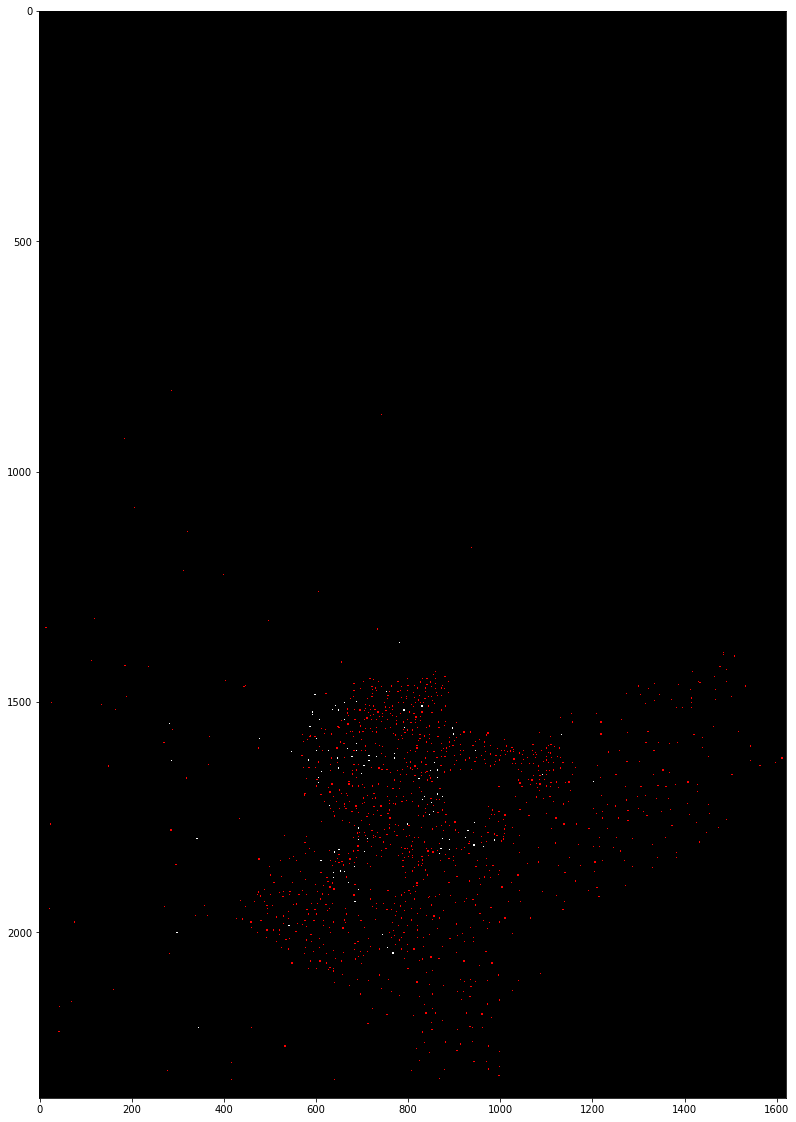

In [76]:
plot_image(blank)

In [77]:
vill_town = make_dict(coords, 0.02, 71)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


118


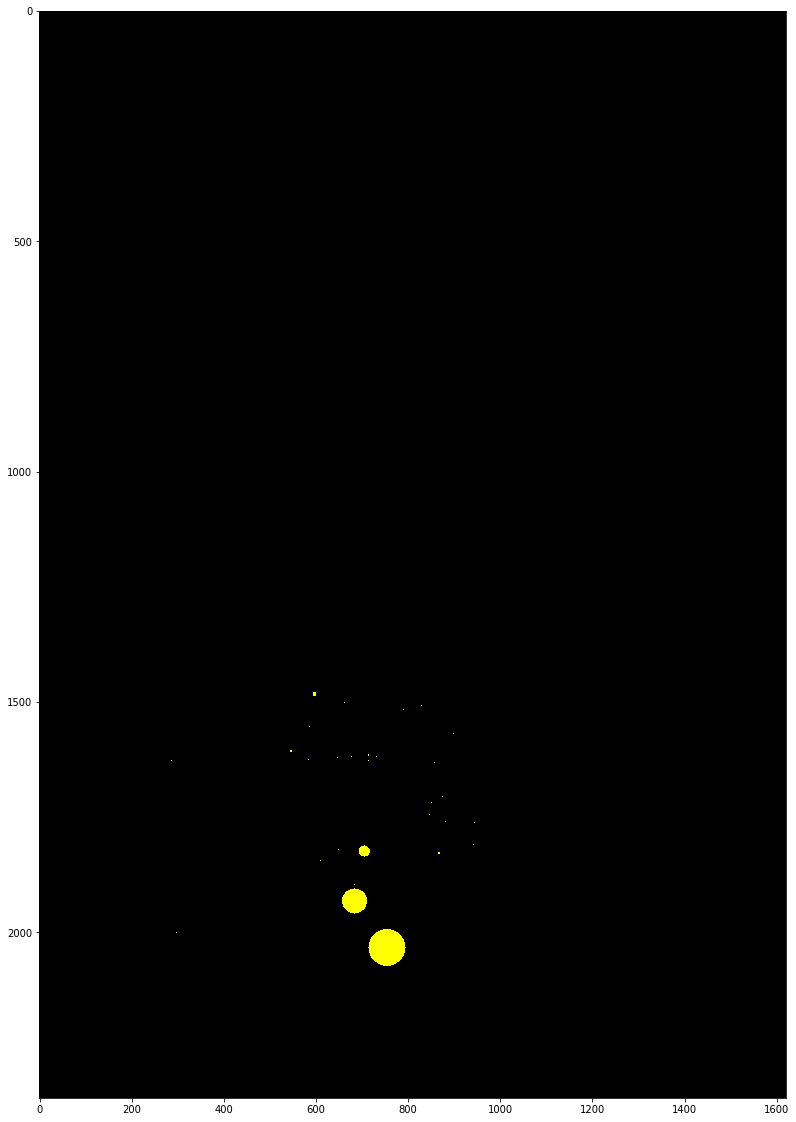

In [78]:
graph1 = np.zeros(shape=[x,y,3])
c = 0
coords_town = []

for i in range(0, bdm_towns.shape[0]):
    lat = bdm_towns.iloc[i, bdm_towns.columns.get_loc("Latitude")]
    long = bdm_towns.iloc[i, bdm_towns.columns.get_loc("Longitude")]
    name = bdm_towns.iloc[i, bdm_towns.columns.get_loc("_Name_")]
    score = bdm_towns.iloc[i, bdm_towns.columns.get_loc("Medical_Score")]
    
    if math.isnan(lat):
        pass
    else:
        coords_town.append((lat, long, name, score, "town"))


d_ = 10

bounds_town = []

for coord in coords_town:
    bound = ret_bound(coord, d)
    bound.append(coord[4]) #alias
    bound.append(coord[2]) #name
    bound.append(coord[3]) #score
    bounds_town.append(bound)
    

parts_town = []

for bound in bounds_town:
    part = sub_part(x,y,bound[0:2],bbox)
    part_ = [part, bound[2], bound[3], bound[4]] #bound[2] -> alias, bound[3] -> name, bound[4] -> score
    parts_town.append(part_)
    
    
for part in parts_town:
    topleft = (part[0][0], part[0][1])
    
    radius = int(part[3]/1000)
    cv2.circle(graph1, topleft, radius, color = (255,255,0), thickness = -1)
    c += 1
plot_image(graph1)
print(c)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2044


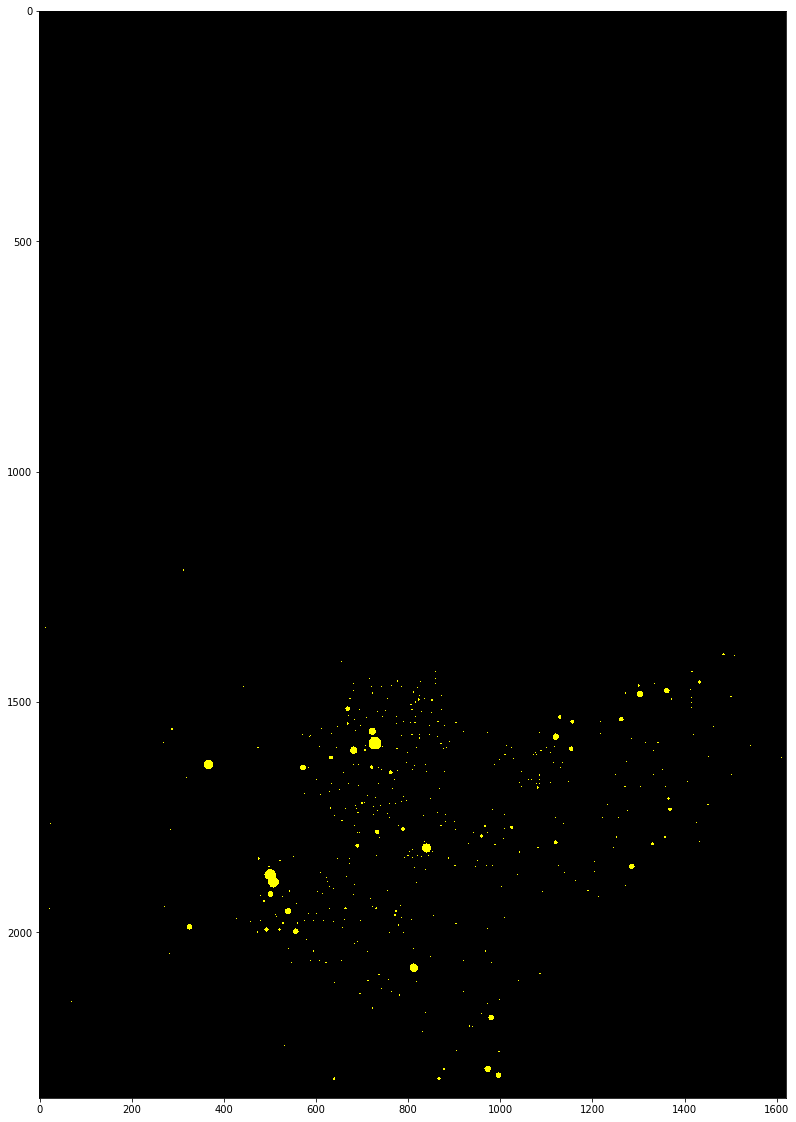

In [79]:
graph2 = np.zeros(shape=[x,y,3])
c = 0
coords_village = []

for i in range(0, bdm_villages.shape[0]):
    lat = bdm_villages.iloc[i, bdm_villages.columns.get_loc("Latitude")]
    long = bdm_villages.iloc[i, bdm_villages.columns.get_loc("Longitude")]
    name = bdm_villages.iloc[i, bdm_villages.columns.get_loc("_Name_")]
    score = bdm_villages.iloc[i, bdm_villages.columns.get_loc("Medical_Score")]
    
    if math.isnan(lat):
        pass
    else:
        coords_village.append((lat, long, name, score, "village"))


d_ = 10

bounds_village = []

for coord in coords_village:
    bound = ret_bound(coord, d)
    bound.append(coord[4]) #alias
    bound.append(coord[2]) #name
    bound.append(coord[3]) #score
    bounds_village.append(bound)
    

parts_village = []

for bound in bounds_village:
    part = sub_part(x,y,bound[0:2],bbox)
    part_ = [part, bound[2], bound[3], bound[4]] #bound[2] -> alias, bound[3] -> name, bound[4] -> score
    parts_village.append(part_)
    
    
for part in parts_village:
    topleft = (part[0][0], part[0][1])
    
    radius = int(part[3]/100)
    cv2.circle(graph2, topleft, radius, color = (255,255,0), thickness = -1)
    c += 1
plot_image(graph2)
print(c)

In [80]:
num = 5

best_med_towns = bdm_towns.sort_values(by = 'Medical_Score', ascending = False).iloc[0:num, :]

In [81]:
best_med_towns

,District Code,District Name,Town Code,_Name_,Town Name,Total Households,Total Population of Town,Total Male Population of Town,Total Female Population of Town,Reference Year,Class,Civic Status of Town,Area (sq. km.),Nearest Ciity Name with Population of 1 Lakh and more,Nearest Ciity with Population of 1 Lakh and more Road Distance (in kms.),Nearest Ciity Name with Population of 5 Lakh and more,Nearest Ciity with Population of 5 Lakh and more Road Distance (in kms.),Hospital Allopathic (Numbers),Hospital Allopathic Beds (Numbers),Hospital Allopathic Doctors-Total Strength (Numbers),Hospital Allopathic Doctors-In Position (Numbers),Hospital Allopathic Para Medical Staff-Total Strength (Numbers),Hospital Allopathic Para Medical Staff-In Postion (Numbers),Hospital Allopathic Nearest facility Distance (in Kms.),Hospital Alternative Medicine (Numbers),Hospital Alternative Medicine Beds (Numbers),Hospital Alternative Medicine Doctors-Total Strength (Numbers),Hospital Alternative Medicine Doctors-In Position (Numbers),Hospital Alternative Medicine Para Medical Staff-Total Strength (Numbers),Hospital Alternative Medicine Para Medical Staff-In Position (Numbers),Hospital Alternative Medicine Nearest facility Distance(in kms.),Dispensary/Health Centre (Numbers),Dispensary/Health Centre Beds (Numbers),Dispensary/Health Centre Doctors-Total Strength (Numbers),Dispensary/Health Centre Doctors-In Position (Numbers),Dispensary/Health Centre Para Medical Staff-Total Strength (Numbers),Dispensary/Health Centre Para Medical Staff-In Position (Numbers),Dispensary/Health Centre Nearest facility Distance (in Kms.),Family Welfare Centre (Numbers),Family Welfare Centre Beds (Numbers),Family Welfare Centre Doctors-Total Strength (Numbers),Family Welfare Centre Doctors-In Position (Numbers),Family Welfare Centre Doctors Para Medical Staff-Total Strength (Numbers),Family Welfare Centre Para Medical Staff-In Position (Numbers),Family Welfare Centre Nearest facility Distance (in kms.),Maternity and Child Welfare Centre (Numbers),Maternity and Child Welfare Centre Beds (Numbers),Maternity and Child Welfare Centre Doctors-Total Strength (Numbers),Maternity and Child Welfare Centre Doctors-In Position (Numbers),Maternity and Child Welfare Centre Para Medical Staff-Total Strength (Numbers),Maternity and Child Welfare Centre Para Medical Staff-In Position (Numbers),Maternity and Child Welfare Centre Nearest facility Distance (in Kms.),Maternity Home (Numbers),Maternity Home Beds (Numbers),Maternity Home Doctors-Total Strength (Numbers),Maternity Home Doctors-In Position (Numbers),Maternity Home Para Medical Staff-Total Strength (Numbers),Maternity Home Para Medical Staff-In position (Numbers),Maternity Home Nearest facility Distance (in kms.),T.B. Hospital/ Clinic (Numbers),T.B. Hospital/ Clinic Beds (Numbers),T.B. Hospital/ Clinic Doctors-Total Strength (Numbers),T.B. Hospital/ Clinic Doctors-In Position (Numbers),T.B. Hospital/Clinic Para Medical Staff-Total Strength (Numbers),T.B. Hospital/Clinic Para Medical Staff-In position (Numbers),T.B. Hospital/ Clinic Nearest facility Distance (in kms.),Nursing Home (Numbers),Nursing Home Beds (Numbers),Nursing Home Doctors-Total Strength (Numbers),Nursing Home Doctor-In Postion (Numbers),Nursing Home Para Medical Staff-Total Strength (Numbers),Nursing Home Para Medical Staff-In Position (Numbers),Nursing Home Nearest facility Distance (in kms.),Veterinary Hospital (Numbers),Veterinary Hospital Beds (Numbers),Veterinary Hospital Doctors-Total Strength (Numbers),Veterinary Hospital Doctors-In Position (Numbers),Veterinary Hospital Para Medical Staff-Total Strength (Numbers),Veterinary Hospital Para Medical Staff-In Position (Numbers),Veterinary Hospital Nearest facility Distance (in kms.),Mobile Health Clinic (Numbers),Mobile Health Clinic Beds (Numbers),Mobile Health Clinic Doctors-Total Strength (Numbers),Mobile Health Clinic Doctors-In Postion (Numbers),Mobile Health Clinic Para Medical Staff-Total Strength (Numbe

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


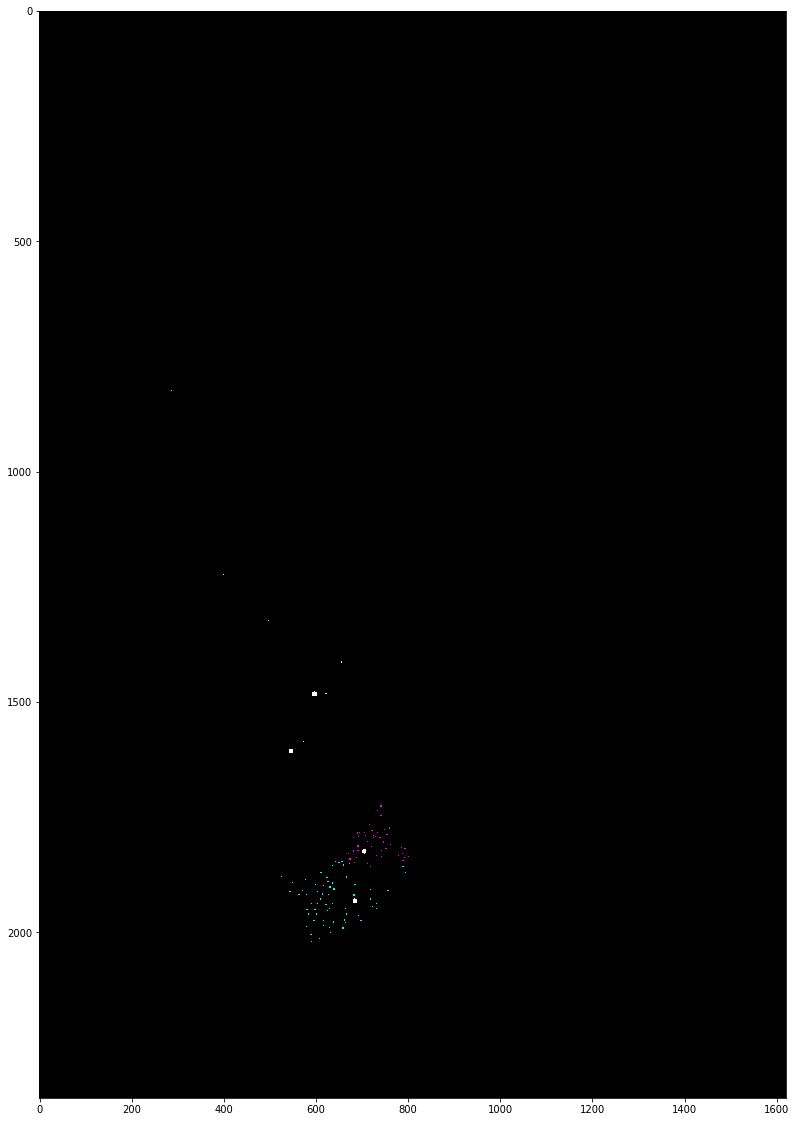

In [83]:
graph3 = np.zeros(shape=[x,y,3])

# The 5 towns of Bardhaman with best Medical facilities are:
#    Guskara   -> Red (255,0,0)
#    Raniganj  -> Cyan (0, 255, 255)
#    Kulti     -> Pink (255, 0, 230)
#    Durgapur  -> Orange (255, 162, 0)
#    Memari    -> Green (85, 255, 0)
#    Towns -> White(255,255,255)


graph3, _ = final_image(graph3, parts, town_name = 'Malta', vill_town = vill_town, town_color = (255,0,0))
graph3, _ = final_image(graph3, parts, town_name = 'Makhal Tala', vill_town = vill_town, town_color = (0,255,255))
graph3, _ = final_image(graph3, parts, town_name = 'Baruipur', vill_town = vill_town, town_color = (255,0,230))
graph3, _ = final_image(graph3, parts, town_name = 'Pujali', vill_town = vill_town, town_color = (255,162,0))
graph3, _ = final_image(graph3, parts, town_name = 'Maheshtala', vill_town = vill_town, town_color = (85,255,0))

plot_image(graph3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


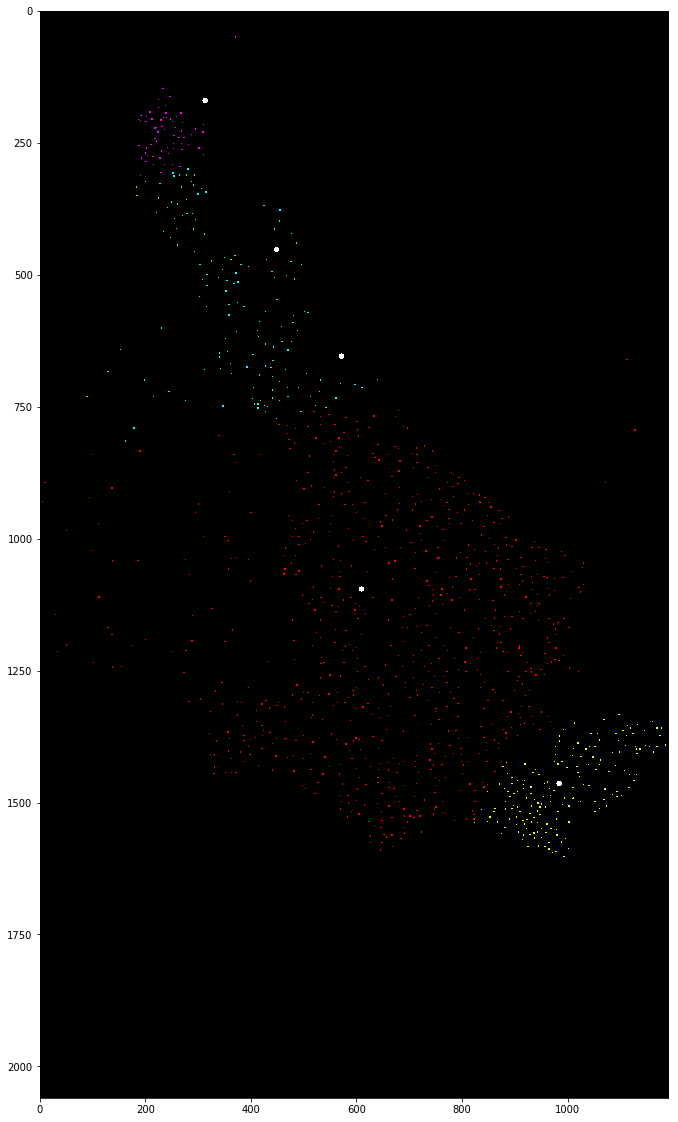

In [51]:
for part in parts:
    if part[2] == 'Durgapur ':
        town_durg = (part[0][0], part[0][1])
        

vv = np.copy(graph3)
cv2.circle(vv, town_durg, 5, (255,255,255),-1)
plot_image(vv)

In [ ]:
place_to_num_town = {}
place_to_num_village = {}
idx = 0
for i in range(0, bdm_towns.shape[0]):
    name_ = bdm_towns.iloc[i, bdm_towns.columns.get_loc('_Name_')]
    place_to_num_town[name_] = idx
    idx += 1
    
idx = 0
for i in range(0, bdm_villages.shape[0]):
    name_ = bdm_villages.iloc[i, bdm_villages.columns.get_loc('_Name_')]
    place_to_num_village[name_] = idx
    idx += 1
    
len(place_to_num_town), len(place_to_num_village)

In [ ]:
final_matrix = np.zeros(shape=[99, 2502])

for vill,town in vill_town.items():
    vill_val = place_to_num_village[vill]
    town_val = place_to_num_town[town+' ']
    final_matrix[town_val][vill_val] = 1

In [53]:
village_medical['District Name'].unique()

array(['Darjiling ', 'Jalpaiguri ', 'Koch Bihar ', 'Uttar Dinajpur',
       'Dakshin Dinajpur', 'Maldah ', 'Murshidabad ', 'Birbhum',
       'Barddhaman ', 'Nadia ', 'North Twenty Four Parganas', 'Hugli ',
       'Bankura ', 'Puruliya', 'Haora ', 'South Twenty Four Parganas',
       'Paschim Medinipur', 'Purba Medinipur', 0,
       'Hamlet                   (Serial Number)'], dtype=object)

In [85]:
bdm_towns[bdm_towns['_Name_'] == 'Diamond Harbour ']

,District Code,District Name,Town Code,_Name_,Town Name,Total Households,Total Population of Town,Total Male Population of Town,Total Female Population of Town,Reference Year,Class,Civic Status of Town,Area (sq. km.),Nearest Ciity Name with Population of 1 Lakh and more,Nearest Ciity with Population of 1 Lakh and more Road Distance (in kms.),Nearest Ciity Name with Population of 5 Lakh and more,Nearest Ciity with Population of 5 Lakh and more Road Distance (in kms.),Hospital Allopathic (Numbers),Hospital Allopathic Beds (Numbers),Hospital Allopathic Doctors-Total Strength (Numbers),Hospital Allopathic Doctors-In Position (Numbers),Hospital Allopathic Para Medical Staff-Total Strength (Numbers),Hospital Allopathic Para Medical Staff-In Postion (Numbers),Hospital Allopathic Nearest facility Distance (in Kms.),Hospital Alternative Medicine (Numbers),Hospital Alternative Medicine Beds (Numbers),Hospital Alternative Medicine Doctors-Total Strength (Numbers),Hospital Alternative Medicine Doctors-In Position (Numbers),Hospital Alternative Medicine Para Medical Staff-Total Strength (Numbers),Hospital Alternative Medicine Para Medical Staff-In Position (Numbers),Hospital Alternative Medicine Nearest facility Distance(in kms.),Dispensary/Health Centre (Numbers),Dispensary/Health Centre Beds (Numbers),Dispensary/Health Centre Doctors-Total Strength (Numbers),Dispensary/Health Centre Doctors-In Position (Numbers),Dispensary/Health Centre Para Medical Staff-Total Strength (Numbers),Dispensary/Health Centre Para Medical Staff-In Position (Numbers),Dispensary/Health Centre Nearest facility Distance (in Kms.),Family Welfare Centre (Numbers),Family Welfare Centre Beds (Numbers),Family Welfare Centre Doctors-Total Strength (Numbers),Family Welfare Centre Doctors-In Position (Numbers),Family Welfare Centre Doctors Para Medical Staff-Total Strength (Numbers),Family Welfare Centre Para Medical Staff-In Position (Numbers),Family Welfare Centre Nearest facility Distance (in kms.),Maternity and Child Welfare Centre (Numbers),Maternity and Child Welfare Centre Beds (Numbers),Maternity and Child Welfare Centre Doctors-Total Strength (Numbers),Maternity and Child Welfare Centre Doctors-In Position (Numbers),Maternity and Child Welfare Centre Para Medical Staff-Total Strength (Numbers),Maternity and Child Welfare Centre Para Medical Staff-In Position (Numbers),Maternity and Child Welfare Centre Nearest facility Distance (in Kms.),Maternity Home (Numbers),Maternity Home Beds (Numbers),Maternity Home Doctors-Total Strength (Numbers),Maternity Home Doctors-In Position (Numbers),Maternity Home Para Medical Staff-Total Strength (Numbers),Maternity Home Para Medical Staff-In position (Numbers),Maternity Home Nearest facility Distance (in kms.),T.B. Hospital/ Clinic (Numbers),T.B. Hospital/ Clinic Beds (Numbers),T.B. Hospital/ Clinic Doctors-Total Strength (Numbers),T.B. Hospital/ Clinic Doctors-In Position (Numbers),T.B. Hospital/Clinic Para Medical Staff-Total Strength (Numbers),T.B. Hospital/Clinic Para Medical Staff-In position (Numbers),T.B. Hospital/ Clinic Nearest facility Distance (in kms.),Nursing Home (Numbers),Nursing Home Beds (Numbers),Nursing Home Doctors-Total Strength (Numbers),Nursing Home Doctor-In Postion (Numbers),Nursing Home Para Medical Staff-Total Strength (Numbers),Nursing Home Para Medical Staff-In Position (Numbers),Nursing Home Nearest facility Distance (in kms.),Veterinary Hospital (Numbers),Veterinary Hospital Beds (Numbers),Veterinary Hospital Doctors-Total Strength (Numbers),Veterinary Hospital Doctors-In Position (Numbers),Veterinary Hospital Para Medical Staff-Total Strength (Numbers),Veterinary Hospital Para Medical Staff-In Position (Numbers),Veterinary Hospital Nearest facility Distance (in kms.),Mobile Health Clinic (Numbers),Mobile Health Clinic Beds (Numbers),Mobile Health Clinic Doctors-Total Strength (Numbers),Mobile Health Clinic Doctors-In Postion (Numbers),Mobile Health Clinic Para Medical Staff-Total Strength (Numbe